In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from core.config import *

from core.prompter import *
from core.datasets import VOC2012SegDataset
from core.data_utils import flatten_cs_dicts, scatter_list, batch_list
from core.pipeline import convert_mllm_responses_into_jsonl_objects, extract_content_from_mllm_responses
from core.utils import parse_text_to_dict
from models.mllm import MLLMGenParams, MLLM_REGISTRY
from core.viz import display_prompt

In [3]:
config = setup_config(BASE_CONFIG, Path('/home/olivieri/exp/src/vlm_diff/cs_diff_config.yml'))

In [4]:
vlm = MLLM_REGISTRY.get('gemma3:12b-it-qat', http_endpoint=config['ollama_http_endpoint'])
vlm_gen_params = MLLMGenParams(seed=config['seed'], **config['vlm']['MLLMGenParams'])

In [5]:
llm_judge = MLLM_REGISTRY.get('gemini-2.0-flash', api_key=config['_google_AI_key'])
llm_judge_gen_params = MLLMGenParams(seed=config['seed'], **config['llm_judge']['MLLMGenParams'])

In [ ]:
seg_dataset = VOC2012SegDataset(
    root_path=config['datasets']['VOC2012_root_path'],
    split='prompts_split',
    device=config['device'],
    resize_size=config['seg']['image_size'],
    center_crop=True,
    with_unlabelled=False,
    mask_prs_path=config['mask_prs_path']
)

In [7]:
await vlm.load_model()
# await vlm.predict_one(["Hi, do you now who I am?"], MLLMGenParams())
# await vlm.predict_batch([["Hi, do you now who I am?"], ["Why is the sky blue?"]], MLLMGenParams())

In [8]:
promptBuilder = PromptBuilder(
    seg_dataset=seg_dataset,
    prompts_path=config['prompts_path'],
    answers_gt_path=config['gt_path'],
    sup_set_gt_path=config['sup_set_gt_path'],
    by_model=config['by_model'],
    alpha=0.6,
    image_size= config['vlm']['image_size'],
    array_size= (32, 32),
    class_map=seg_dataset.get_class_map(with_unlabelled=False), # imported from 'class_map.py'
    color_map=seg_dataset.get_color_map_dict(with_unlabelled=False),
    split_by=config['split_by']
)



In [9]:
prompt_modules_vars = config['prompt_modules_vars']

promptBuilder.load_modules(
    context_module = ContextModule(variation=prompt_modules_vars['context']),
    color_map_module = ClassSplitted_ColorMapModule(variation=prompt_modules_vars['color_map']),
    input_format_module = SepMasks_Ovr_InputFormatModule(prompt_modules_vars['input_format']),
    task_module = TaskModule(variation=prompt_modules_vars['task']),
    output_format_module = OutputFormatModule(variation=prompt_modules_vars['output_format']),
    support_set_module = SupportSetModule(variation=prompt_modules_vars['support_set'], sup_set_idxs=config['vlm']['sup_set_img_idxs']),
    query_module = QueryModule(variation=prompt_modules_vars['support_set']),
    eval_module = EvalModule(variation=prompt_modules_vars['eval'])
)

---

# Example

In [11]:
ex_query_idx = 5
ex_query_uid = seg_dataset.image_UIDs[ex_query_idx]
ex_query_uid

np.str_('2007_000063')

In [12]:
ex_cs_inference_prompt = promptBuilder.build_class_splitted_inference_prompts(ex_query_idx)
ex_cs_inference_prompt.keys()

dict_keys([9, 12, 18])

I am in a binary semantic segmentation context and I want to compare a **prediction** mask with a **ground truth** mask, both segmented over the same **scene**.


In both masks, a color-class mapping is applied: the white color is mapped to the CHAIR class, while the black color refers to unlabelled classes.


I will give you two images: the first image is the ground truth mask, the second image is the prediction mask.
Both images are overlaid with the scene to support your analysis.


## Instructions

Your task is to find where and how the prediction deviates from the ground truth. Assume the ground truth to be correct. If there are no significant deviations, simply say it.


To help you, I will give you a set of example images, each associated with an ideal answer, which might mention classes whose names are irrelevant to your problem.


EXAMPLE 1.

Input:

Ground Truth.

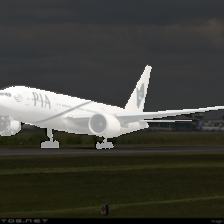

Prediction.

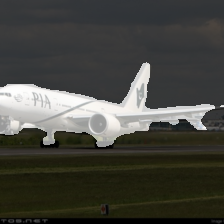

Output:

The ground truth AEROPLANE region has been segmented quite well by the prediction, but the boundaries are imprecise and less defined.

Now, I ask you to generate the output based on the following input. Remember the considered class is the CHAIR class, reference it explicitly in the answer.


Input:

Ground Truth.

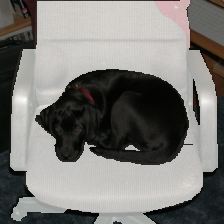

Prediction.

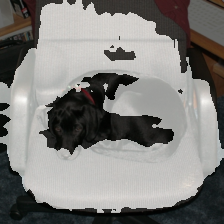

Output:

In [13]:
display_prompt(ex_cs_inference_prompt[9])

In [79]:
ex_flat_cs_inference_prompts, ex_flat_pos_classes, ex_cs_indices = flatten_cs_dicts([ex_cs_inference_prompt])
ex_scattered_uids = scatter_list([ex_query_uid], ex_cs_indices)
ex_scattered_idxs = scatter_list([ex_query_idx], ex_cs_indices)
len(ex_flat_cs_inference_prompts)

3

In [81]:
ex_answer_prs = await vlm.predict_batch(ex_flat_cs_inference_prompts, gen_params=vlm_gen_params)
len(ex_answer_prs)

3

In [14]:
cs_pos_classes = [list(cs_inf_prompt.keys()) for cs_inf_prompt in [ex_cs_inference_prompt]]
ex_flat_cs_eval_prompt = [promptBuilder.build_cs_eval_prompt(img_idx, content, pos_c) for img_idx, content, pos_c in zip(ex_scattered_idxs, extract_content_from_mllm_responses(ex_answer_prs), ex_flat_pos_classes)]
len(ex_flat_cs_eval_prompt)

3

In [15]:
display_prompt(ex_flat_cs_eval_prompt[0])

You are an intelligent chatbot designed for evaluating the correctness of AI assistant predictions for question-answer pairs.
Your task is to compare the predicted answer with the ground-truth answer and determine if the predicted answer is correct or not. Here's how you can accomplish the task:

------

## INSTRUCTIONS:
- Focus on the correctness, completeness and accuracy of the predicted answer with the ground-truth.
- Consider predictions with less or more specific details (as long as they show some consistency with the ground truth) as correct evaluation.
- Be strict with your evaluations.
- Expect precision from the predicted answer, it is not enough for it to roughly capture the essence of the ground truth, the prediction has to overlap sufficiently to the ground truth to be considered correct.
- Be critical of significant inconsistencies of error types and spatial locations.

Please evaluate the following answer:

Ground truth correct Answer:
The prediction has many deviations from the ground truth and is overall much more chaotic. The prediction mask of the ground truth DOG region on the center is severely incomplete and irregular. The CHAIR region taking most of the scene has been segmented in a more irregular and erratic way, and the boundaries are inaccurate. Some area have been misclassified as SOFA instead of CHAIR on the top edge, and some has been misclassified as CHAIR instead of DOG in the center.


Predicted Answer:
The prediction fails to correctly segment the CHAIR class. The ground truth mask accurately identifies the CHAIR, but the prediction mask incorrectly labels the dog as unlabelled (black). The boundaries of the CHAIR are also less defined in the prediction compared to the ground truth.


Provide your evaluation as a correct/incorrect prediction along with the score where the score is an integer value between 0 (fully wrong) and 5 (fully correct). The middle score provides the percentage of correctness.
Please generate the response in the form of a Python dictionary string with keys 'pred', 'score' and 'reason', where value of 'pred' is a string of 'correct' or 'incorrect', value of 'score' is in INTEGER, not STRING and value of 'reason' should provide the reason behind the decision.
Only provide the Python dictionary string. Escape properly quotes within the 'reason' string.
For example, your response should look like this: {'pred': 'correct', 'score': 4, 'reason': reason}.

### Important:
The predicted answer only covers the class CHAIR: restrict your focus exclusively on the CHAIR class, you must ignore all the statements in the ground truth that consider different classes.
If the ground-truth answer does not mention the class CHAIR, assume is it saying that "Both masks have no CHAIR in them, so there is no deviation".


In [ ]:
ex_eval_prs = await llm_judge.predict_batch(ex_flat_cs_eval_prompt, gen_params=llm_judge_gen_params)

In [17]:
ex_eval_prs = extract_content_from_mllm_responses(ex_eval_prs)
ex_eval_prs = [parse_text_to_dict(eval_pr) for eval_pr in ex_eval_prs]
len(ex_eval_prs)

3

In [18]:
ex_eval_prs

[{'pred': 'correct',
  'score': 4,
  'reason': 'The predicted answer correctly identifies that the CHAIR class is not segmented correctly and that the boundaries are less defined compared to the ground truth. It focuses on the CHAIR class as requested.'},
 {'pred': 'correct',
  'score': 4,
  'reason': "The predicted answer accurately describes the deviation in the DOG class segmentation between the prediction and the ground truth. It correctly identifies the missing portion of the DOG's body on the right side and the fragmented boundary. It also mentions the inclusion of regions outside the DOG in the prediction, which are black in the ground truth."},
 {'pred': 'incorrect',
  'score': 1,
  'reason': 'The predicted answer focuses solely on the SOFA class, stating significant deviations. However, the ground truth does not mention any SOFA class at all. The predicted answer is therefore incorrect.'}]

---

# Batch Answering

In [ ]:
epoch_idxs = [x for x in list(range(20)) if x not in promptBuilder.sup_set_idxs]
epoch_uids = seg_dataset.image_UIDs[epoch_idxs]
len(epoch_idxs)

6

In [11]:
cs_inference_prompts = [promptBuilder.build_class_splitted_inference_prompts(q_idx) for q_idx in epoch_idxs]
len(cs_inference_prompts)

6

In [12]:
flat_cs_inference_prompts, flat_pos_classes, batch_indices = flatten_cs_dicts(cs_inference_prompts)
scattered_uids = scatter_list(epoch_uids, batch_indices)
scattered_idxs = scatter_list(epoch_idxs, batch_indices)
len(flat_cs_inference_prompts)

10

In [13]:
exp_path: Path = config['prs_root_path'] / config["exp_name_"]
exp_path.mkdir(exist_ok=True)
jsonlio = JsonlIO()

In [14]:
answers_jsonl_file_path = exp_path / 'answers.jsonl'
jsonlio.append_many_to_jsonl(answers_jsonl_file_path, [{"state": promptBuilder.get_state()} | {"vlm": f"{vlm.__class__.__name__}:{vlm.model}"}])

In [15]:
answer_prs_text = []
for step, batch in enumerate(batch_list(zip(flat_cs_inference_prompts, scattered_idxs, scattered_uids, flat_pos_classes), config['vlm']['batch_size'])):
    prompts_b, idxs_b, uids_b, pos_classes_b = zip(*batch)
    answer_prs_b = await vlm.predict_batch(prompts_b, gen_params=vlm_gen_params)
    answer_prs_text.extend(extract_content_from_mllm_responses(answer_prs_b)) # for the eval prompt building
    answer_jsonl_objects_b = convert_mllm_responses_into_jsonl_objects(idxs_b, uids_b, pos_classes_b, answer_prs_b)
    jsonlio.append_many_to_jsonl(answers_jsonl_file_path, answer_jsonl_objects_b)
    print(f"batch {step+1} of size {len(batch)} finished.")

batch 1 of size 2 finished.
batch 2 of size 2 finished.
batch 3 of size 2 finished.
batch 4 of size 2 finished.
batch 5 of size 2 finished.


In [16]:
cs_pos_classes = [list(cs_inf_prompt.keys()) for cs_inf_prompt in cs_inference_prompts]
flat_cs_eval_prompt = [promptBuilder.build_cs_eval_prompt(img_idx, content, pos_c) for img_idx, content, pos_c in zip(scattered_idxs, answer_prs_text, flat_pos_classes)]
len(flat_cs_eval_prompt)

10

In [17]:
eval_jsonl_file_path = exp_path / 'evals.jsonl'
jsonlio.append_many_to_jsonl(eval_jsonl_file_path, [{"state": promptBuilder.get_state()} | {"vlm": f"{vlm.__class__.__name__}:{vlm.model}"}])

In [ ]:
for step, batch in enumerate(batch_list(zip(flat_cs_eval_prompt, scattered_idxs, scattered_uids, flat_pos_classes), config['llm_judge']['batch_size'])):
    prompts_b, idxs_b, uids_b, pos_classes_b = zip(*batch)
    eval_prs_b = await llm_judge.predict_batch(prompts_b, gen_params=llm_judge_gen_params)
    for resp in eval_prs_b:
        resp.text = parse_text_to_dict(resp.text)
    eval_jsonl_objects_b = convert_mllm_responses_into_jsonl_objects(idxs_b, uids_b, pos_classes_b, eval_prs_b)
    jsonlio.append_many_to_jsonl(eval_jsonl_file_path, eval_jsonl_objects_b)
    print(f"batch {step+1} of size {len(batch)} finished.")

Attempt 1/3 failed with ClientError: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.\n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 200\nPlease retry in 27.028903058s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.0-flash'}, 'quotaValue': '200'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.R

ClientError: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.\n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 200\nPlease retry in 26.461323731s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.0-flash'}, 'quotaValue': '200'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '26s'}]}}

# Fast Prompt Builder

In [ ]:
prompt_blueprint={
    "context": "default",
    "color_map": "default",
    "input_format": "sep_ovr_original",
    "task": "default",
    "output_format": "default",
    "support_set_intro": "default",
    "support_set_item": "default",
    "query": "default",
}

In [20]:
sup_set_seg_dataset = VOC2012SegDataset(
    root_path=config['datasets']['VOC2012_root_path'],
    device=config['device'],
    split='prompts_split',
    resize_size=config['seg']['image_size'],
    center_crop=True,
    with_unlabelled=False,
    mask_prs_path=config['mask_prs_path']
)

In [24]:
fast_prompt_builder = FastPromptBuilder(
    seg_dataset=seg_dataset,
    prompts_file_path=config['prompts_path'] / 'fast_cs_prompt.json',
    prompt_blueprint=prompt_blueprint,
    by_model=config['by_model'],
    alpha=0.6,
    class_map=seg_dataset.get_class_map(with_unlabelled=False),
    color_map=seg_dataset.get_color_map_dict(with_unlabelled=False),
    image_size=config['vlm']['image_size'],
    sup_set_img_idxs=[16],
    sup_set_gt_path=config['answers_path']['sup_set_gt'],
    sup_set_seg_dataset=sup_set_seg_dataset,
    str_formats=None,
    seed=config["seed"],
)

In [27]:
fast_prompt_builder.build_cs_inference_prompts_from_disk(query_idxs=epoch_idxs)

[{1: ['I am in a binary semantic segmentation context and I want to compare a **prediction** mask with a **ground truth** mask, both segmented over the same **scene**.\n',
   'In both masks, a color-class mapping is applied: the white color is mapped to the AEROPLANE class, while the black color refers to unlabelled classes.\n',
   'I will give you two images: the first image is the ground truth mask, the second image is the prediction mask.\nBoth images are overlaid with the scene to support your analysis.\n',
   '## Instructions\n\nYour task is to find where and how the prediction deviates from the ground truth. Assume the ground truth to be correct. If there are no significant deviations, simply say it.\n',
   'I provide some examples of correct outputs:\n- "Overall, the prediction captured most of the ground truth regions, however, the ground truth SKY region on the top left of the scene has been segmented quite coarsely, some details are missed, while the prediction mask of the gr